First all, I checked the data distribution.

Second, I conducted data cleaning by , remove outliers, drop unneccessary columns, create new meaning columns, convert datatype, convert dummie variables.

Then checked the correlation between variabls, decide to log the price and varaibles related with sqft to normalize the distribution

The most important parts is to play around with combination of variables using OSL model to identify the variables used for building the model by check their P-value, removed those variables with P-value greater than 5%. 

After the data cleaning and identify variables. I build OSL, Ridge, LASSO, and Elastic models, and checked the influencers, leveraging, residual plots. 

Overall, in my analysis, OSL model perform thee best result with the least MSE. 


After exclude some variables with high correlation which caused multicolleanrity. we found 'lat' which reprents location impact the price the most, the other impacting orders from high to low are: log_sqft_living 15, log_sqft_above, grade, view, year(selling year), house_age, bedrooms, however, log_sqft_lot15 have negative impact to price. 

In [2750]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2751]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import scipy. stats as stats
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [2752]:
df = pd.read_csv(r"C:\MY FILE\MBAN 6110S-Data Science\assignment3\kc_house_data.csv")

In [2753]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [2754]:
df.describe(include='all')

id             date         price      bedrooms     bathrooms   sqft_living      sqft_lot        floors    waterfront          view     condition         grade    sqft_above  sqft_basement      yr_built  yr_renovated       zipcode           lat          long  sqft_living15     sqft_lot15
count   2.161300e+04            21613  2.161300e+04  21613.000000  21613.000000  21613.000000  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   21613.000000  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   21613.000000   21613.000000
unique           NaN              372           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN            NaN           NaN           NaN           NaN           NaN           NaN            NaN            NaN
top              NaN  20140623T000000           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN            NaN           NaN           NaN           NaN           NaN           NaN            NaN            NaN
freq             NaN              142           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN            NaN           NaN           NaN           NaN           NaN           NaN            NaN            NaN
mean    4.580302e+09              NaN  5.400881e+05      3.370842      2.114757   2079.899736  1.510697e+04      1.494309      0.007542      0.234303      3.409430      7.656873   1788.390691     291.509045   1971.005136     84.402258  98077.939805     47.560053   -122.213896    1986.552492   12768.455652
std     2.876566e+09              NaN  3.671272e+05      0.930062      0.770163    918.440897  4.142051e+04      0.539989      0.086517      0.766318      0.650743      1.175459    828.090978     442.575043     29.373411    401.679240     53.505026      0.138564      0.140828     685.391304   27304.179631
min     1.000102e+06              NaN  7.500000e+04      0.000000      0.000000    290.000000  5.200000e+02      1.000000      0.000000      0.000000      1.000000      1.000000    290.000000       0.000000   1900.000000      0.000000  98001.000000     47.155900   -122.519000     399.000000     651.000000
25%     2.123049e+09              NaN  3.219500e+05      3.000000      1.750000   1427.000000  5.040000e+03      1.000000      0.000000      0.000000      3.000000      7.000000   1190.000000       0.000000   1951.000000      0.000000  98033.000000     47.471000   -122.328000    1490.000000    5100.000000
50%     3.904930e+09              NaN  4.500000e+05      3.000000      2.250000   1910.000000  7.618000e+03      1.500000      0.000000      0.000000      3.000000      7.000000   1560.000000       0.000000   1975.000000      0.000000  98065.000000     47.571800   -122.230000    1840.000000    7620.000000
75%     7.308900e+09              NaN  6.450000e+05      4.000000      2.500000   2550.000000  1.068800e+04      2.000000      0.000000      0.000000      4.000000      8.000000   2210.000000     560.000000   1997.000000      0.000000  98118.000000     47.678000   -122.125000    2360.000000   10083.000000
max     9.900000e+09              NaN  7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06      3.500000      1.000000      4.000000      5.000000     13.000000   9410.000000    4820.000000   2015.000000   2015.000000  98199.000000     47.777600   -121.315000    6210.000000  871200.000000

Data quality issues 
- convert datatype:  
        ' date' /''yr_built'/ 'yr_renovated' / 'zipcode'

- Remove outliers
     

- convert to dummie variables: 'waterfront', 'view', 'grade','condition


In [2755]:
# convert datatype
df['date'] = pd.to_datetime(df['date'])
#df['yr_built'] = pd.to_datetime(df['yr_built'])
#df['yr_renovated'] = pd.to_datetime(df['yr_renovated'])
df['zipcode'].astype(object)
df['waterfront'].astype(bool)
df['view'].astype(object)
df['grade'].astype(object)


0         7
1         7
2         6
3         7
4         8
5        11
6         7
7         7
8         7
9         7
10        8
11        7
12        7
13        7
14        7
15        9
16        7
17        7
18        7
19        7
20        7
21        9
22        8
23        7
24        8
25        6
26        8
27        8
28        7
29        8
30        8
31        7
32        7
33        8
34        7
35        8
36        5
37        8
38        7
39        8
40        9
41        8
42        9
43        7
44        6
45        8
46        6
47        9
48        7
49        9
50        7
51        8
52        7
53        7
54        8
55        9
56        7
57        8
58        8
59        8
60        8
61        7
62        8
63        8
64        7
65        7
66       10
67        7
68        7
69        8
70       11
71        7
72        7
73        8
74        7
75       10
76        7
77        7
78        7
79       10
80        8
81        7
82        7
83  

In [2756]:
current_year = datetime.datetime.now().year
df['house_age'] = current_year - df['yr_built']
df['reno_age'] = current_year - df['yr_renovated']
#df['price_per_sqft'] = df['price']/df['sqft_living']

In [2757]:
# create dummie variables 
#dummies_view = pd.get_dummies(df.view, prefix= 'view', dtype= int)
#dummies_waterfront = pd.get_dummies(df.waterfront, prefix='wf',dtype =int)
#dummies_grade = pd.get_dummies(df.grade, prefix='grade', dtype = int)
#dummies_condition = pd.get_dummies(df.condition, prefix='condition', dtype= int)
#df = pd.concat([df,dummies_view,dummies_waterfront,dummies_condition,dummies_grade], axis=1)

#df2.head()


In [2758]:
# extract year, month and create new columns 
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [2759]:
#drop columns
df = df.drop('id', axis=1)
df = df.drop('date', axis=1)

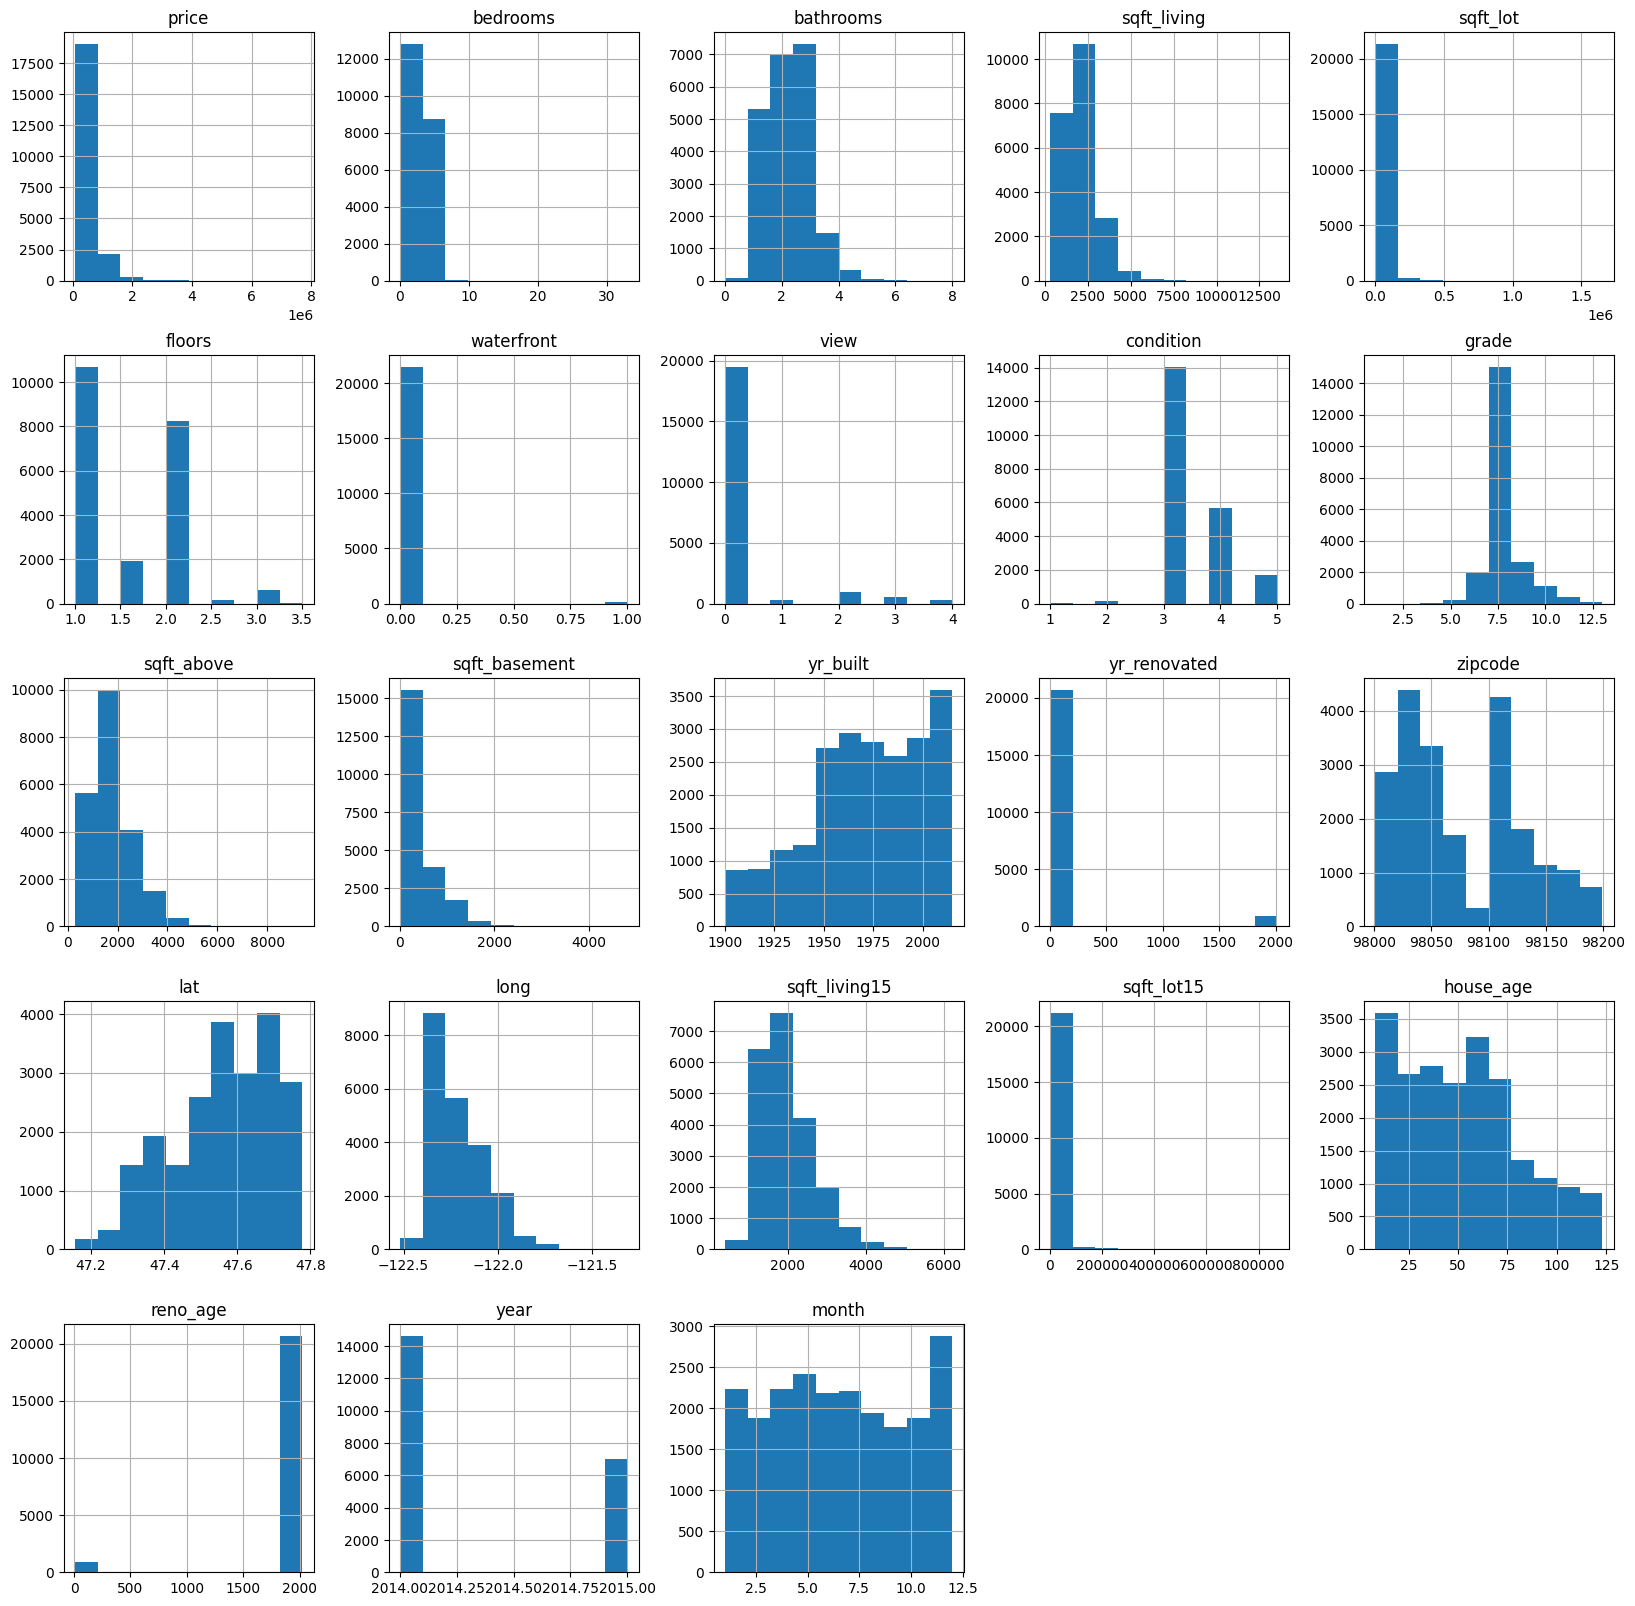

In [2760]:
# check the distributions
df.hist(figsize=(20,20))
plt.show()

 drop outliers which are fall outside of boxplot

Text(0.5, 1.0, 'bedrooms')

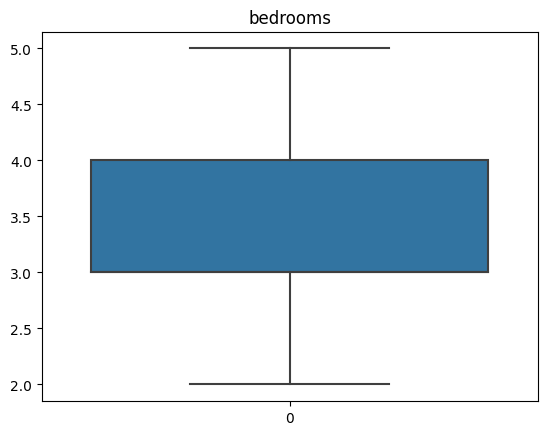

In [2761]:
df = df.drop(df[df['bedrooms'] > 5].index)
df = df.drop(df[df['bedrooms'] < 2].index)
sns.boxplot(df['bedrooms'])
plt.title('bedrooms')



Text(0.5, 1.0, 'sqft_living')

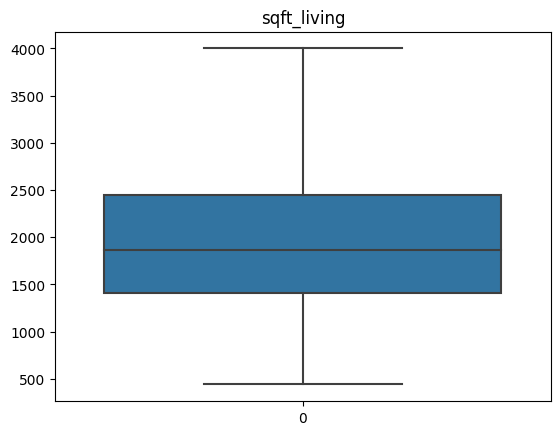

In [2762]:
df = df.drop(df[df['sqft_living'] > 4000].index)
df = df.drop(df[df['sqft_living'] < 290].index)
sns.boxplot(df['sqft_living'])
plt.title('sqft_living')

In [2763]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'house_age', 'reno_age', 'year',
       'month'],
      dtype='object')

Text(0.5, 1.0, 'bathrooms')

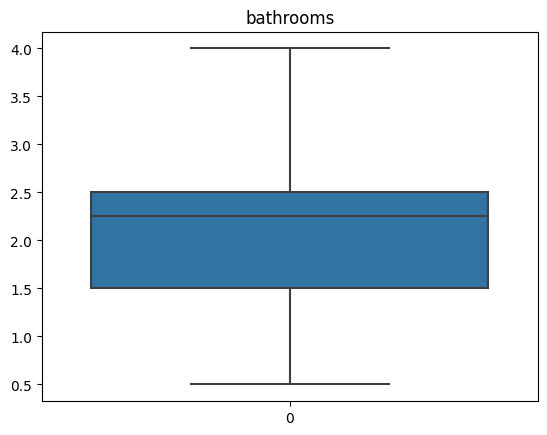

In [2764]:
df = df.drop(df[df['bathrooms'] >4].index)
sns.boxplot(df['bathrooms'])
plt.title('bathrooms')

In [2765]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'house_age', 'reno_age', 'year',
       'month'],
      dtype='object')

Text(0.5, 1.0, 'sqft_lot')

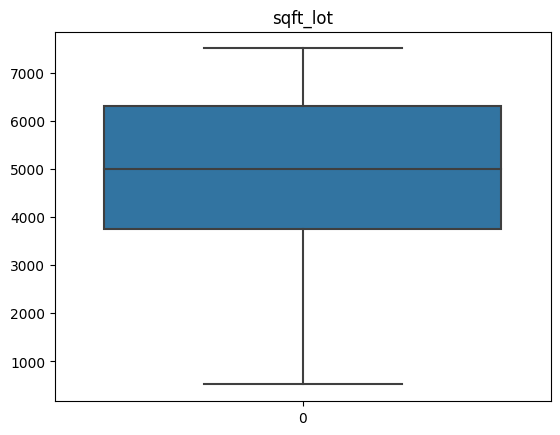

In [2766]:
df = df.drop(df[(df['sqft_lot'] > 7500)].index)
df = df.drop(df[df['sqft_lot'] < 520].index)
sns.boxplot(df['sqft_lot'])
plt.title('sqft_lot')

Text(0.5, 1.0, 'sqft_basement')

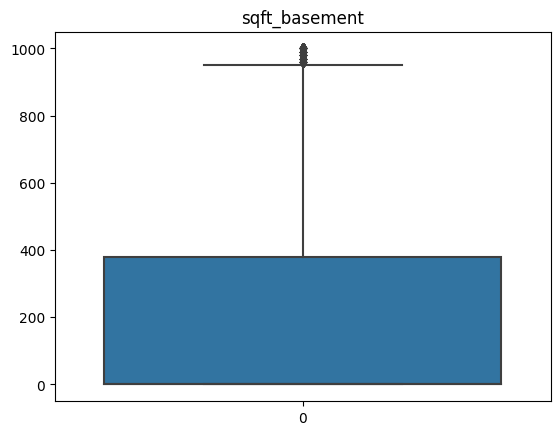

In [2767]:
df = df.drop(df[df['sqft_basement'] >1000].index)
sns.boxplot(df['sqft_basement'])
plt.title('sqft_basement')

Text(0.5, 1.0, 'sqft_living15')

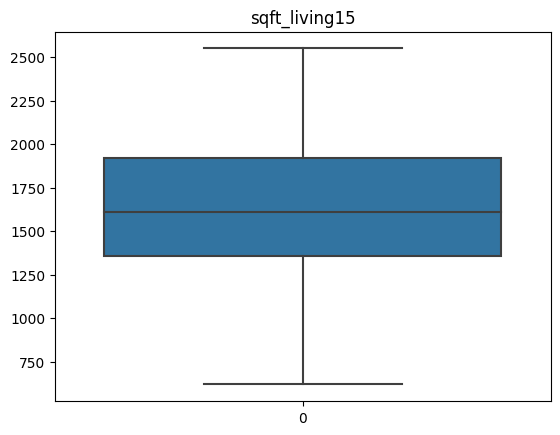

In [2768]:
df = df.drop(df[df['sqft_living15'] >2550].index)
sns.boxplot(df['sqft_living15'])
plt.title('sqft_living15')

In [2769]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'house_age', 'reno_age', 'year',
       'month'],
      dtype='object')

Text(0.5, 1.0, 'sqft_lot15')

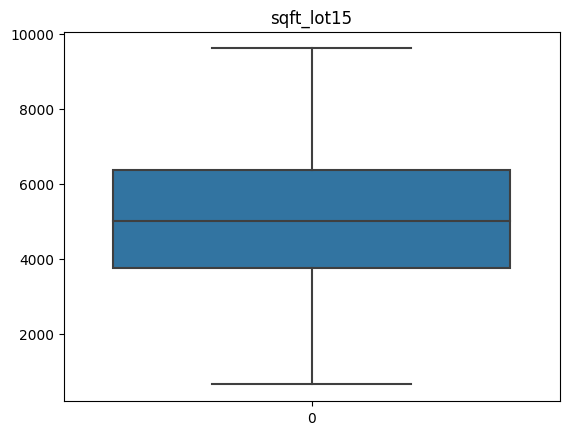

In [2770]:
df = df.drop(df[df['sqft_lot15'] >9621].index)
sns.boxplot(df['sqft_lot15'])
plt.title('sqft_lot15')

In [2771]:
df = df.drop(df[df['sqft_above'] > 1800].index)
df = df.drop(df[df['sqft_above'] < 1190].index)



In [2772]:
df['sqft_above'].astype(int)


6        1715
17       1600
25       1710
26       1750
27       1400
31       1190
32       1510
34       1280
35       1510
43       1570
48       1250
63       1540
65       1770
71       1260
88       1610
93       1290
94       1290
101      1440
107      1240
116      1590
119      1610
123      1720
128      1720
133      1390
138      1190
150      1360
158      1270
171      1670
176      1320
177      1220
180      1670
181      1680
188      1330
195      1690
214      1720
225      1250
226      1510
229      1480
234      1620
237      1670
242      1430
250      1240
254      1730
260      1460
265      1700
273      1300
294      1270
337      1510
363      1340
369      1370
370      1430
379      1300
398      1260
400      1290
405      1330
406      1290
407      1570
433      1490
438      1270
447      1260
462      1510
466      1480
491      1680
496      1710
498      1190
506      1210
528      1590
531      1360
535      1610
538      1360
541      1560
557   

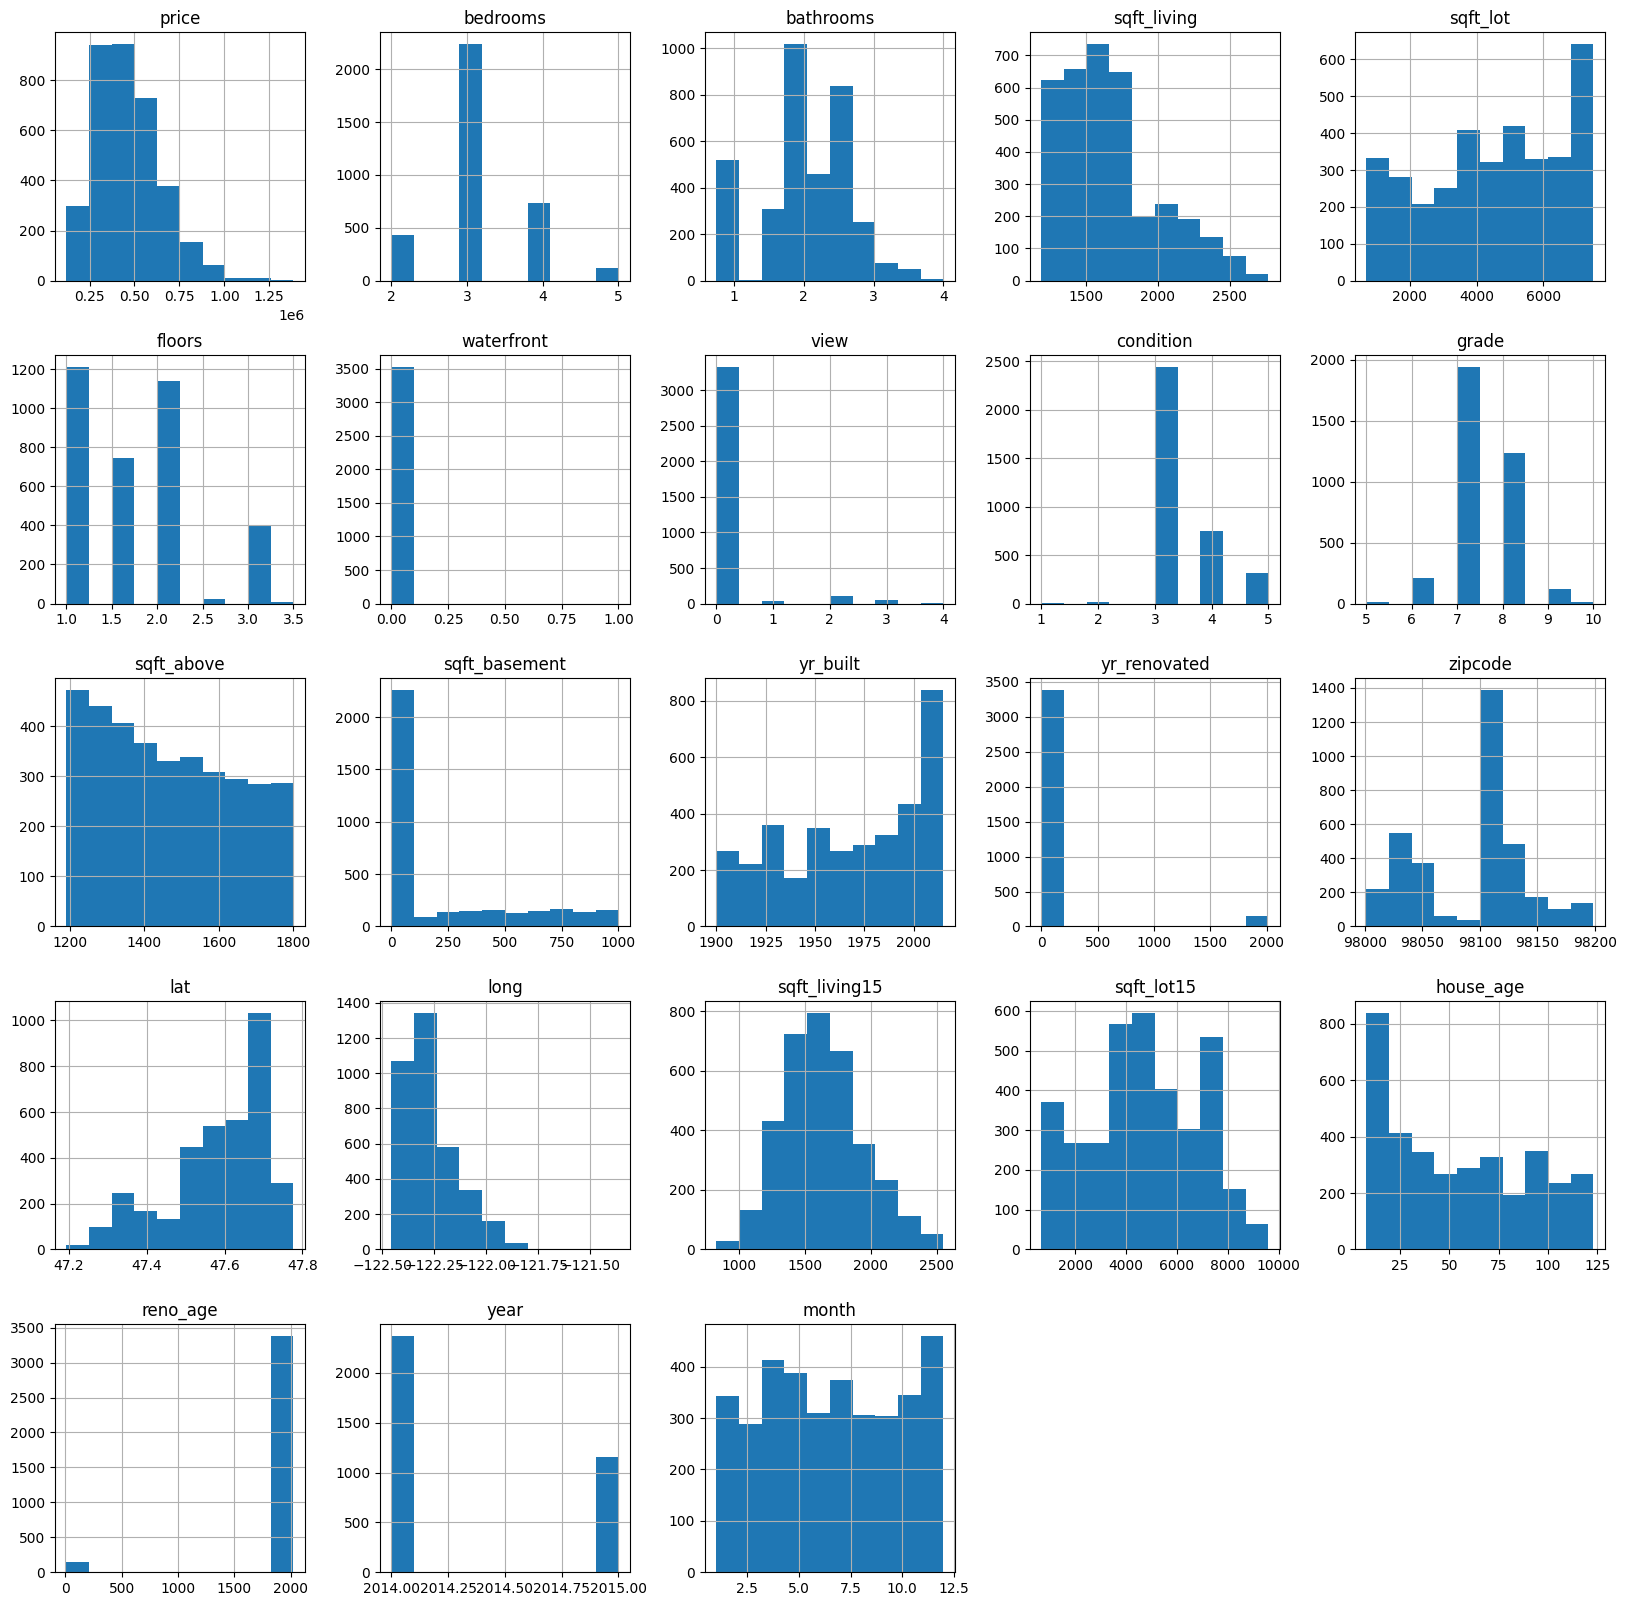

In [2773]:
# check the distributions
df.hist(figsize=(20,20))
plt.show()

By checking correlations , to select the variables for building models


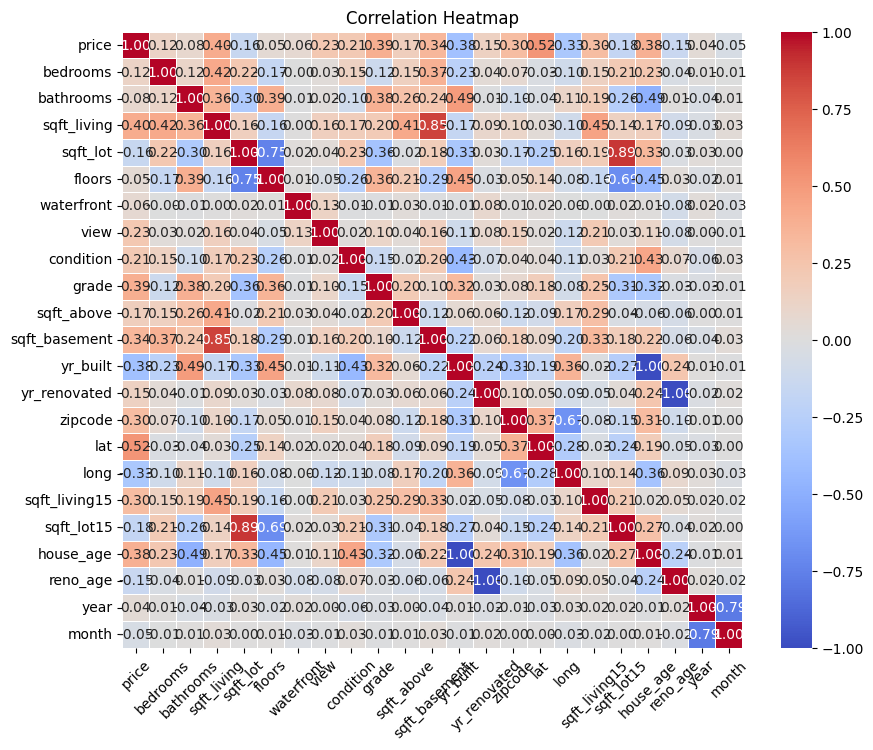

In [2774]:
df_corr = df.corr()
df_corr

plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(df_corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')  # Set the title of the heatmap
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)  # Keep y-axis labels as they are
plt.show()

using stastic model 

In [2775]:
correlations = df.corr()['price'].sort_values(ascending=False)
correlations

price            1.000000
lat              0.521590
sqft_living      0.402409
grade            0.390598
house_age        0.378639
sqft_basement    0.343677
zipcode          0.304309
sqft_living15    0.303818
view             0.225217
condition        0.211344
sqft_above       0.167206
yr_renovated     0.148396
bedrooms         0.123762
bathrooms        0.079858
waterfront       0.064072
floors           0.054278
year             0.043461
month           -0.054574
reno_age        -0.148396
sqft_lot        -0.155314
sqft_lot15      -0.176452
long            -0.326024
yr_built        -0.378639
Name: price, dtype: float64

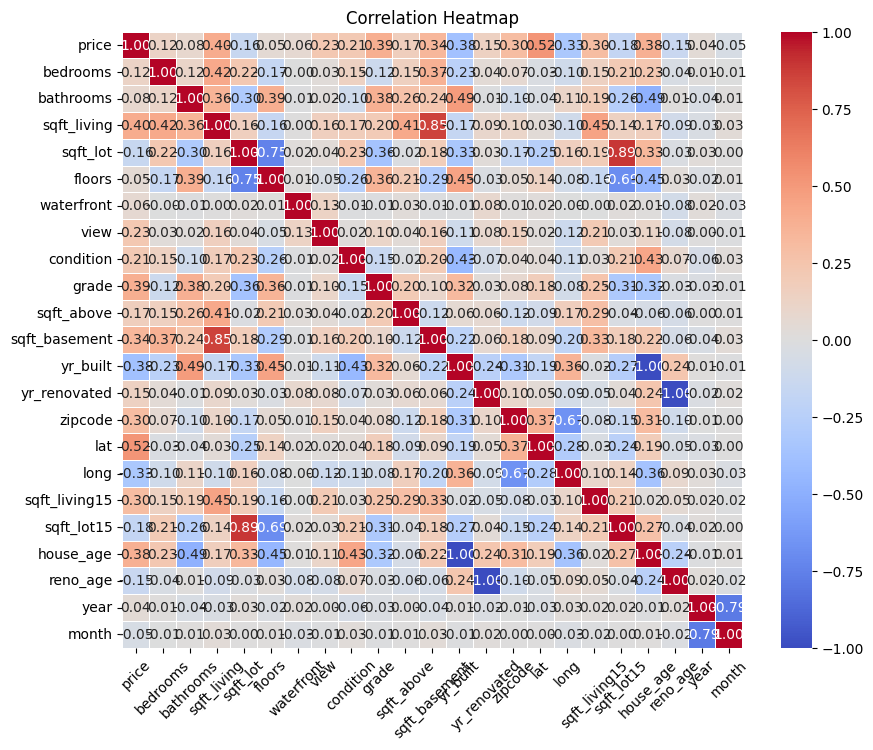

In [2776]:
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(df_corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')  # Set the title of the heatmap
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)  # Keep y-axis labels as they are
plt.show()

In [2777]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'house_age', 'reno_age', 'year',
       'month'],
      dtype='object')

In [2778]:
#  log 'price', 'sqft_living', 'sqft_above', 'sqft_living15'
df['log_price'] = np.log(df['price'])
df['log_sqft_living'] = np.log(df['sqft_living'])
df['log_sqft_lot'] =np.log(df['sqft_lot'])
df['log_sqft_above'] = np.log(df['sqft_above'])
df['log_sqft_living15'] = np.log(df['sqft_living15'])
df['log_sqft_basement'] = np.log(df['sqft_basement'])
df['log_sqft_lot15'] =np.log(df['sqft_lot15'])



C:\Users\mei88\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [2779]:
df2 = df.drop(['price', 'sqft_living', 'sqft_above', 'sqft_lot','sqft_basement', 'sqft_living15','sqft_lot15'], axis=1)


In [2780]:
df2.columns

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'house_age', 'reno_age', 'year', 'month', 'log_price',
       'log_sqft_living', 'log_sqft_lot', 'log_sqft_above',
       'log_sqft_living15', 'log_sqft_basement', 'log_sqft_lot15'],
      dtype='object')

In [2781]:
df2_corr = df2.corr()
df2_corr

bedrooms  bathrooms    floors  waterfront      view  condition     grade  yr_built  yr_renovated   zipcode       lat      long  house_age  reno_age      year     month  log_price  log_sqft_living  log_sqft_lot  log_sqft_above  log_sqft_living15  log_sqft_basement  log_sqft_lot15
bedrooms           1.000000   0.116730 -0.166477   -0.003932  0.027789   0.147182 -0.119357 -0.231157      0.040668  0.068965 -0.028958 -0.098312   0.231157 -0.040668  0.013790 -0.005507   0.107579         0.415416      0.242637        0.149003           0.138419           0.371515        0.225788
bathrooms          0.116730   1.000000  0.389909   -0.007891  0.017475  -0.101759  0.377993  0.490599     -0.009494 -0.099684 -0.038291  0.111311  -0.490599  0.009494 -0.044198  0.013340   0.093540         0.369073     -0.315120        0.260006           0.200366           0.103947       -0.285358
floors            -0.166477   0.389909  1.000000    0.008694 -0.046370  -0.255198  0.359013  0.452456     -0.030333  0.053794  0.140321 -0.082897  -0.452456  0.030333 -0.023809  0.011075   0.082024        -0.149473     -0.791141        0.207081          -0.139842          -0.456564       -0.732758
waterfront        -0.003932  -0.007891  0.008694    1.000000  0.127007  -0.009887 -0.009111 -0.013554      0.080311  0.010726  0.020185 -0.002628   0.013554 -0.080311  0.024134 -0.030493   0.042023         0.006318      0.015710        0.026708           0.001300                NaN        0.017895
view               0.027789   0.017475 -0.046370    0.127007  1.000000   0.021012  0.101967 -0.109339      0.075030  0.152630  0.017877 -0.121358   0.109339 -0.075030  0.004063 -0.012427   0.202592         0.158269      0.042157        0.035956           0.191743           0.053770        0.040889
condition          0.147182  -0.101759 -0.255198   -0.009887  0.021012   1.000000 -0.149919 -0.430442     -0.072887  0.035533  0.036822 -0.106569   0.430442  0.072887 -0.055525  0.031113   0.185446         0.157768      0.254360       -0.017065           0.016582           0.240283        0.247048
grade             -0.119357   0.377993  0.359013   -0.009111  0.101967  -0.149919  1.000000  0.319068      0.028446  0.075988  0.179265 -0.081084  -0.319068 -0.028446 -0.027716 -0.013423   0.401805         0.209585     -0.389068        0.204616           0.262195          -0.105672       -0.332665
yr_built          -0.231157   0.490599  0.452456   -0.013554 -0.109339  -0.430442  0.319068  1.000000     -0.235588 -0.307657 -0.186189  0.364803  -1.000000  0.235588  0.008189 -0.012601  -0.343245        -0.150051     -0.415356        0.059179          -0.001841          -0.260124       -0.357804
yr_renovated       0.040668  -0.009494 -0.030333    0.080311  0.075030  -0.072887  0.028446 -0.235588      1.000000  0.096490  0.045673 -0.085415   0.235588 -1.000000 -0.024015  0.020767   0.129485         0.083075      0.054073        0.061593          -0.058600           0.079256        0.058410
zipcode            0.068965  -0.099684  0.053794    0.010726  0.152630   0.035533  0.075988 -0.307657      0.096490  1.000000  0.370547 -0.668785   0.307657 -0.096490 -0.005729  0.002433   0.318167         0.090052     -0.149407       -0.118728          -0.080669           0.027316       -0.124087
lat               -0.028958  -0.038291  0.140321    0.020185  0.017877   0.036822  0.179265 -0.186189      0.045673  0.370547  1.000000 -0.283822   0.186189 -0.045673 -0.026648  0.001413   0.608644         0.021898     -0.244337       -0.089126          -0.026364          -0.041982       -0.232964
long              -0.098312   0.111311 -0.082897   -0.002628 -0.121358  -0.106569 -0.081084  0.364803     -0.085415 -0.668785 -0.283822  1.000000  -0.364803  0.085415  0.027701 -0.027089  -0.318365        -0.084020      0.171289        0.166149           0.100265          -0.025630        0.135442
house_age          0.231157  -0.490599 -0.452456    0.013554  0.109339   0.430442 -0.319068 -1.000000      0.235588  0.307657  0.186

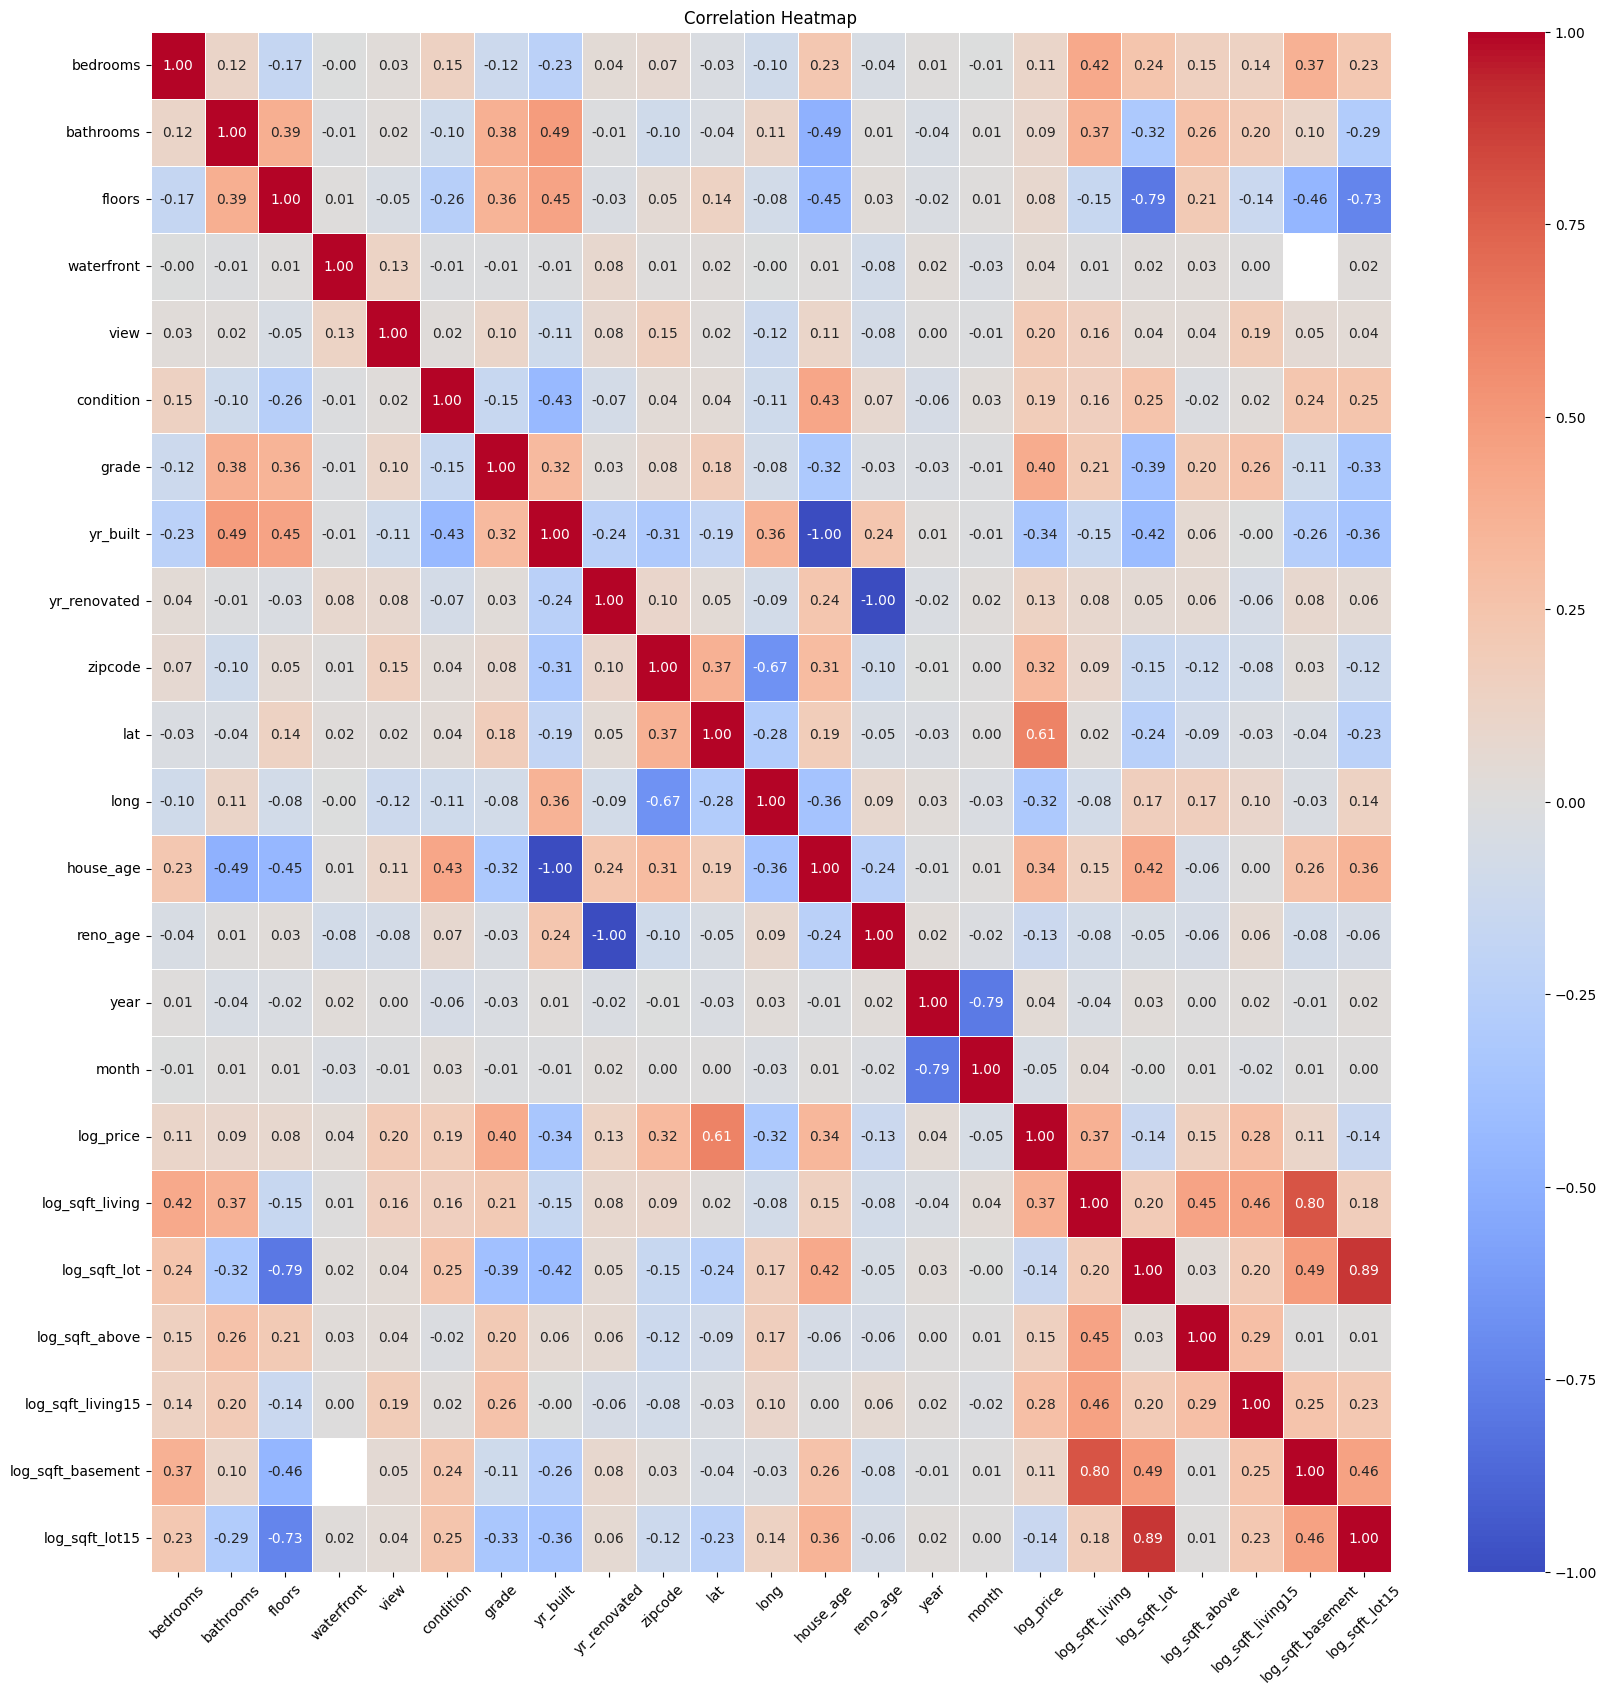

In [2782]:

plt.figure(figsize=(20, 20))  # Set the figure size
sns.heatmap(df2_corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')  # Set the title of the heatmap
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)  # Keep y-axis labels as they are
plt.show()

Log_sqft_lot and log_sqft_lot15 are highly correlated, we will only choose 1 then , after comparing, we will keep log_sqft_lot15 & log_sqft_living15

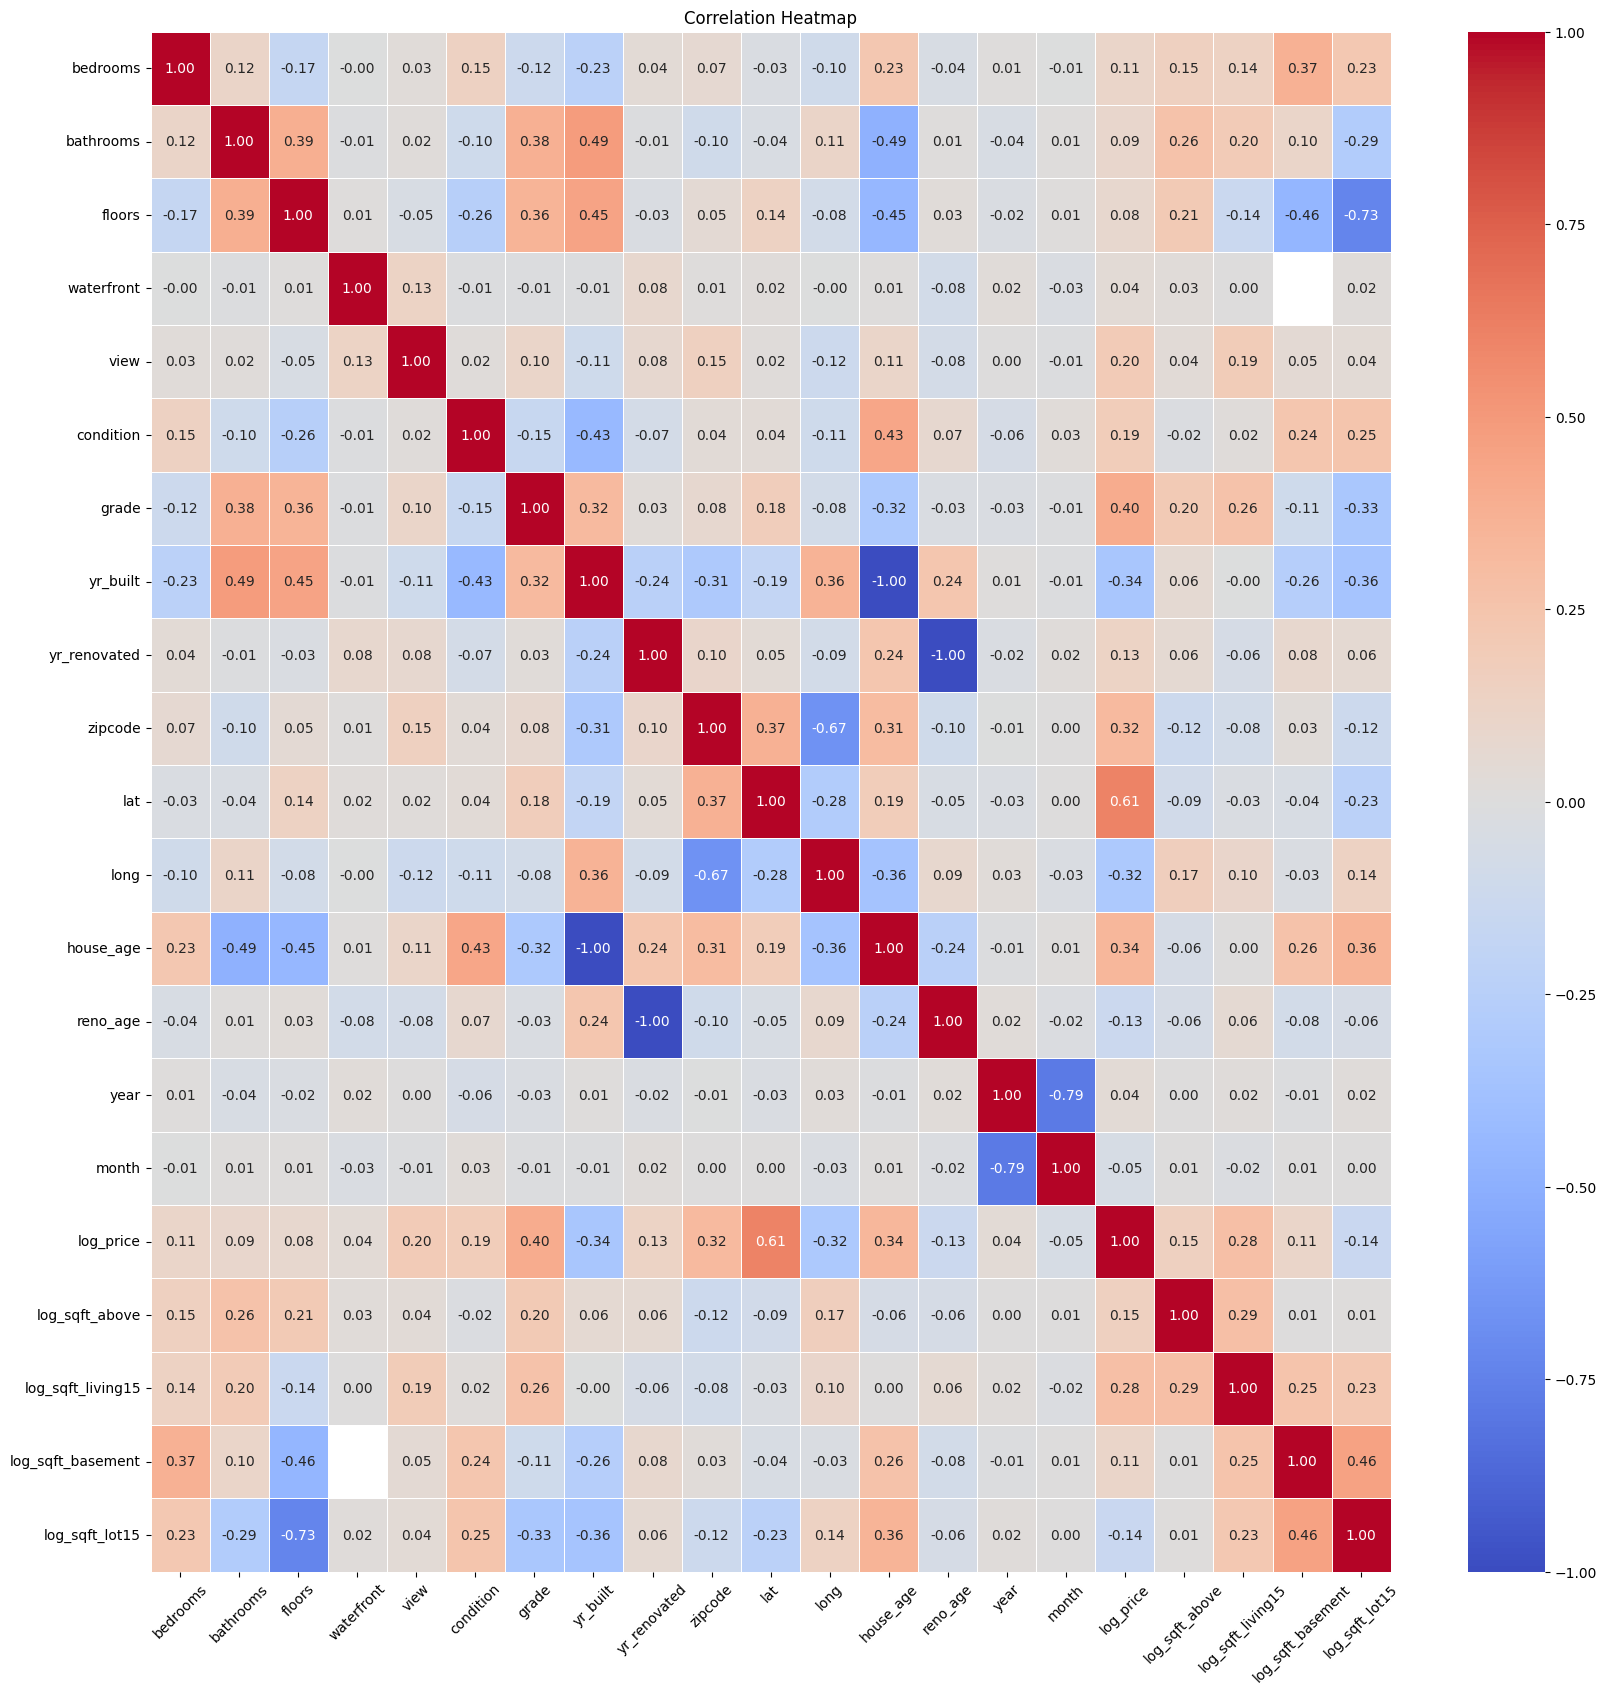

In [2783]:
df3 = df2.drop(['log_sqft_living', 'log_sqft_lot'], axis=1)
df3_corr = df3.corr()
plt.figure(figsize=(20, 20))  # Set the figure size
sns.heatmap(df3_corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')  # Set the title of the heatmap
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)  # Keep y-axis labels as they are
plt.show()

we look at which variables' parameters

In [2784]:
correlations = df3.corr()['log_price'].sort_values(ascending=False)
correlations

log_price            1.000000
lat                  0.608644
grade                0.401805
house_age            0.343245
zipcode              0.318167
log_sqft_living15    0.283419
view                 0.202592
condition            0.185446
log_sqft_above       0.151053
yr_renovated         0.129485
log_sqft_basement    0.109110
bedrooms             0.107579
bathrooms            0.093540
floors               0.082024
waterfront           0.042023
year                 0.040371
month               -0.052795
reno_age            -0.129485
log_sqft_lot15      -0.143241
long                -0.318365
yr_built            -0.343245
Name: log_price, dtype: float64

log_sqft_living, log_sqft_above, log_sqft_basement, log_sqft_lot, log_sqft_living15, log_sqft_lot15 are still correlated. 
so we need to remove these variables from the model. 

Run a OLS model, try different combination of variables and screened out below variables. 
zipcode, waterfront, month, log_sqft_basement, floor , reno_age, condition, long, bathroom

In [2785]:
#dummies_view = pd.get_dummies(df3.view, prefix= 'view', dtype= int)
#dummies_waterfront = pd.get_dummies(df.waterfront, prefix='wf',dtype =int)
#dummies_grade = pd.get_dummies(df.grade, prefix='grade', dtype = int)
#dummies_bedrooms = pd.get_dummies(df3.bedrooms, prefix='bedrooms', dtype= int)
#dummies_year = pd.get_dummies(df3.year, prefix='year', dtype= int)
#df4 = pd.concat([df3,dummies_view,dummies_bedrooms,dummies_year], axis=1)


In [2786]:
df3.columns

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'house_age', 'reno_age', 'year', 'month', 'log_price', 'log_sqft_above',
       'log_sqft_living15', 'log_sqft_basement', 'log_sqft_lot15'],
      dtype='object')

In [2787]:
model_ols = ols('log_price ~  bedrooms + view +grade + lat + year +log_sqft_above + log_sqft_living15 + log_sqft_lot15 + house_age', data = df3)
result_model_ols = model_ols.fit()
print(result_model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     754.9
Date:                Wed, 12 Jul 2023   Prob (F-statistic):               0.00
Time:                        18:04:27   Log-Likelihood:                 171.19
No. Observations:                3527   AIC:                            -322.4
Df Residuals:                    3517   BIC:                            -260.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -168.7985     16.80

In [2788]:
variables =['bedrooms','view', 'grade',  'lat',  'year', 'log_sqft_above', 'log_sqft_living15', 'log_sqft_lot15','house_age']
correlations = df3[variables].corr()
print(correlations)

                   bedrooms      view     grade       lat      year  log_sqft_above  log_sqft_living15  log_sqft_lot15  house_age
bedrooms           1.000000  0.027789 -0.119357 -0.028958  0.013790        0.149003           0.138419        0.225788   0.231157
view               0.027789  1.000000  0.101967  0.017877  0.004063        0.035956           0.191743        0.040889   0.109339
grade             -0.119357  0.101967  1.000000  0.179265 -0.027716        0.204616           0.262195       -0.332665  -0.319068
lat               -0.028958  0.017877  0.179265  1.000000 -0.026648       -0.089126          -0.026364       -0.232964   0.186189
year               0.013790  0.004063 -0.027716 -0.026648  1.000000        0.002556           0.017293        0.019033  -0.008189
log_sqft_above     0.149003  0.035956  0.204616 -0.089126  0.002556        1.000000           0.285707        0.010595  -0.059179
log_sqft_living15  0.138419  0.191743  0.262195 -0.026364  0.017293        0.285707       

In [2789]:
pred_val = result_model_ols.predict(df3[['bedrooms','view', 'grade',  'lat',  'year', 'log_sqft_above', 'log_sqft_living15', 'log_sqft_lot15','house_age']])

In [2790]:
pred_val

6        12.484917
17       13.274362
25       12.244926
26       13.480590
27       13.437352
31       12.845054
32       13.175334
34       12.610576
35       13.406486
43       13.209804
48       12.871573
63       13.035020
65       13.060094
71       13.084027
88       12.858124
93       13.297404
94       13.297404
101      13.191387
107      12.514962
116      13.077562
119      13.181966
123      13.115469
128      13.309456
133      12.906395
138      12.523476
150      13.097236
158      12.342693
171      12.530811
176      12.804902
177      12.830402
180      12.461609
181      13.046265
188      13.046528
195      12.676042
214      13.094953
225      12.700637
226      13.090284
229      13.028474
234      13.044150
237      13.284024
242      13.171696
250      12.451651
254      12.462621
260      13.404495
265      12.622916
273      12.626842
294      13.528864
337      13.361745
363      13.002093
369      12.664197
370      12.556323
379      13.223893
398      12.

In [2849]:
res = pd.concat([pred_val.to_frame().rename(columns = {0:'predict_val'}), df3['log_price']],axis=1)
print(res)
res['error'] = res['predict_val'] - res['log_price']
res['sq_error'] = res['error']**2
print(res)
MSE_OSL = np.sqrt(res['sq_error'].mean())
print(MSE_OSL)

       predict_val  log_price
6        12.484917  12.458775
17       13.274362  13.091904
25       12.244926  12.358794
26       13.480590  13.750439
27       13.437352  13.410545
31       12.845054  12.542545
32       13.175334  13.440817
34       12.610576  12.683858
35       13.406486  13.453105
43       13.209804  13.437174
48       12.871573  13.017003
63       13.035020  13.215854
65       13.060094  12.668627
71       13.084027  12.691580
88       12.858124  12.278393
93       13.297404  12.971540
94       13.297404  13.458836
101      13.191387  13.226723
107      12.514962  12.146853
116      13.077562  13.158695
119      13.181966  13.190022
123      13.115469  13.005830
128      13.309456  13.620104
133      12.906395  13.024190
138      12.523476  12.854484
150      13.097236  13.184718
158      12.342693  12.417144
171      12.530811  12.513557
176      12.804902  12.899095
177      12.830402  12.860999
180      12.461609  12.468437
181      13.046265  13.060488
188      1

(array([1.000e+00, 2.000e+01, 1.460e+02, 7.890e+02, 1.364e+03, 8.450e+02,
        2.900e+02, 5.700e+01, 1.200e+01, 3.000e+00]),
 array([-1.00523191, -0.78850987, -0.57178783, -0.35506579, -0.13834375,
         0.07837829,  0.29510033,  0.51182237,  0.72854441,  0.94526645,
         1.16198849]),
 <BarContainer object of 10 artists>)

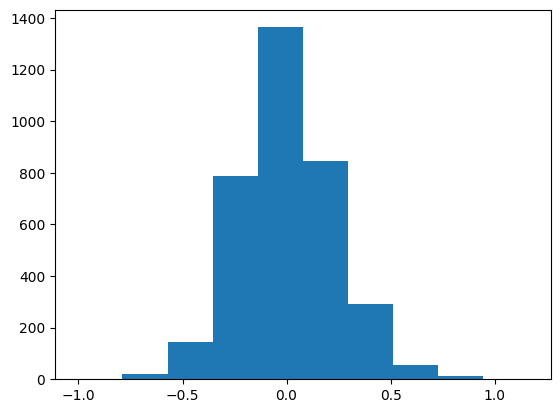

In [2792]:
plt.hist(res['error'])


(array([ 16.,  64., 240., 536., 634., 827., 726., 371.,  97.,  16.]),
 array([11.69524702, 11.93984339, 12.18443976, 12.42903612, 12.67363249,
        12.91822886, 13.16282523, 13.40742159, 13.65201796, 13.89661433,
        14.1412107 ]),
 <BarContainer object of 10 artists>)

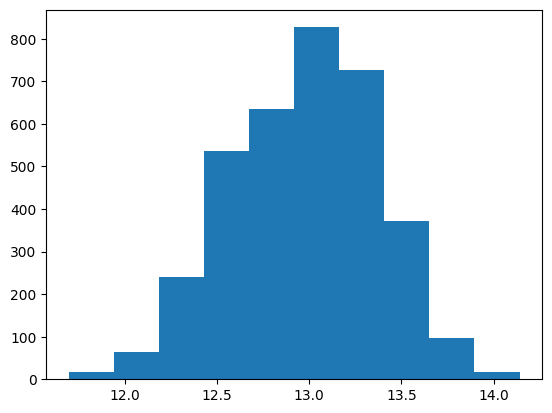

In [2793]:
plt.hist(df3['log_price'])


Text(0.5, 0, '#_of_bedrooms')

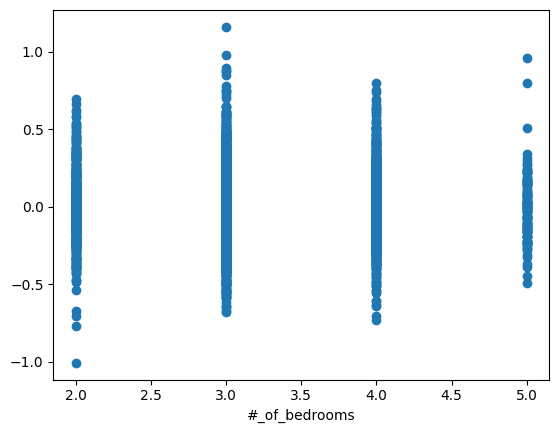

In [2794]:
plt.scatter(df3['bedrooms'], res['error'])
plt.xlabel('#_of_bedrooms')

Text(0.5, 0, 'view')

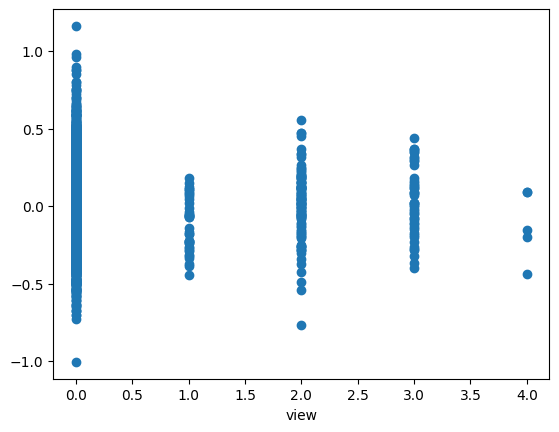

In [2795]:
plt.scatter(df3['view'], res['error'])
plt.xlabel('view')

Text(0.5, 0, 'grade')

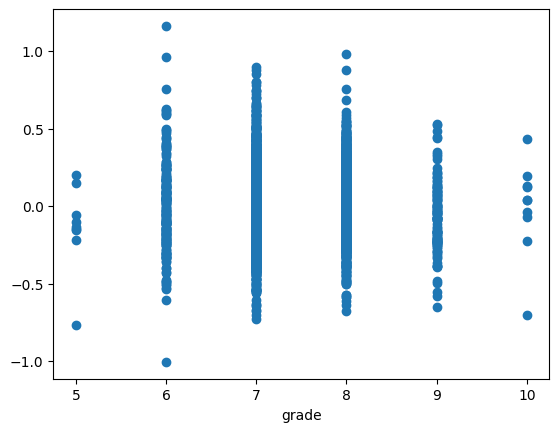

In [2796]:
plt.scatter(df3['grade'], res['error'])
plt.xlabel('grade')

Text(0.5, 0, 'lat')

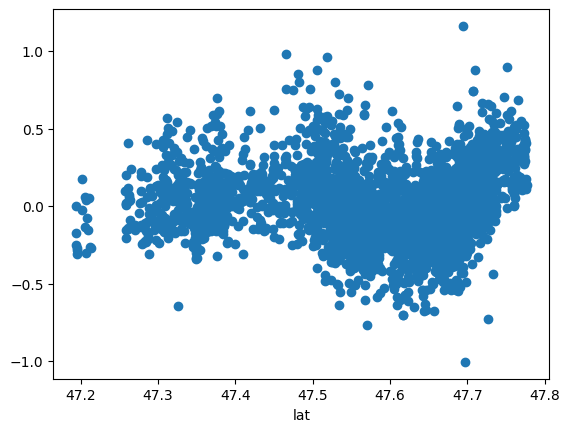

In [2797]:
plt.scatter(df3['lat'], res['error'])
plt.xlabel('lat')

Text(0.5, 0, 'year')

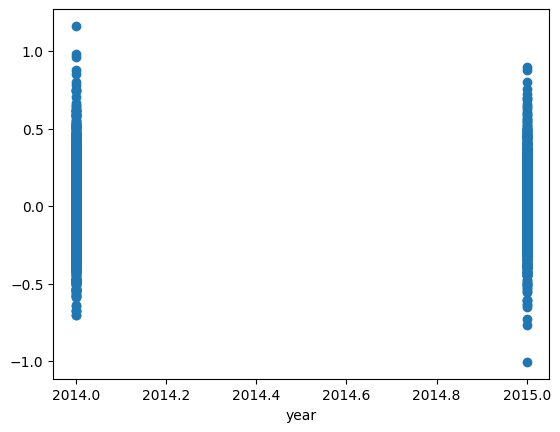

In [2798]:
plt.scatter(df3['year'], res['error'])
plt.xlabel('year')

Text(0.5, 0, 'log_sqft_above')

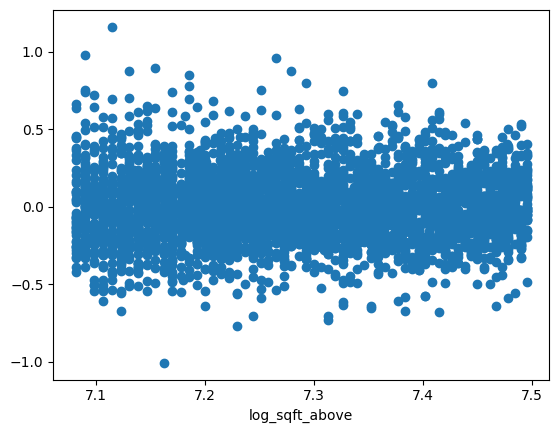

In [2799]:
plt.scatter(df3['log_sqft_above'], res['error'])
plt.xlabel('log_sqft_above')

Text(0.5, 0, 'log_sqft_living15')

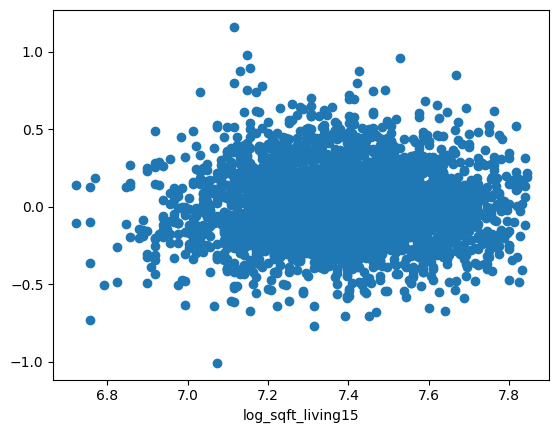

In [2800]:
plt.scatter(df3['log_sqft_living15'], res['error'])
plt.xlabel('log_sqft_living15')

Text(0.5, 0, 'log_sqft_lot15')

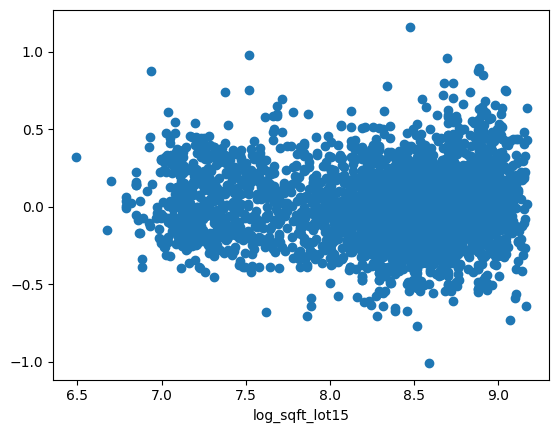

In [2801]:
plt.scatter(df2['log_sqft_lot15'], res['error'])
plt.xlabel('log_sqft_lot15')

Text(0.5, 0, 'house_age')

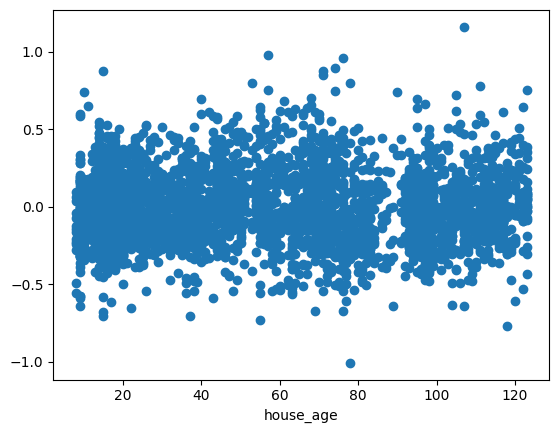

In [2802]:
plt.scatter(df2['house_age'], res['error'])
plt.xlabel('house_age')

((array([-3.5447314 , -3.30376139, -3.17065333, ...,  3.17065333,
          3.30376139,  3.5447314 ]),
  array([-1.00523191, -0.76727409, -0.72621866, ...,  0.96126244,
          0.98298594,  1.16198849])),
 (0.229696760107831, -2.5241894703656795e-13, 0.995578792330129))

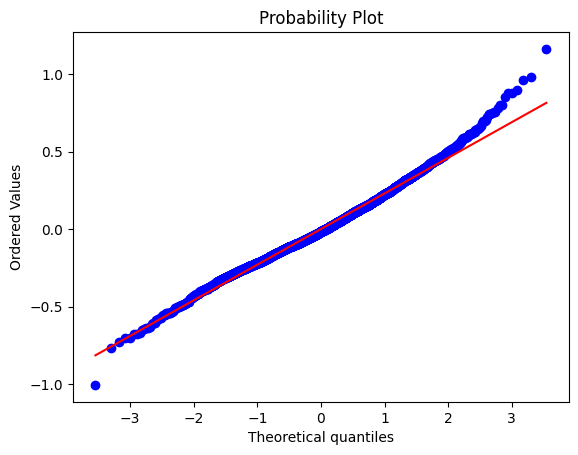

In [2803]:
import scipy. stats as stats
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(res['error'], dist ='norm', plot = ax)


In [2804]:
infl = result_model_ols.get_influence()
print(infl.summary_frame().head())

    dfb_Intercept  dfb_bedrooms  dfb_view  dfb_grade   dfb_lat  dfb_year  dfb_log_sqft_above  dfb_log_sqft_living15  dfb_log_sqft_lot15  dfb_house_age   cooks_d  standard_resid  hat_diag  dffits_internal  student_resid    dffits
6       -0.001777      0.001246  0.000749   0.001851  0.003058  0.001542           -0.001759              -0.003201           -0.000022       0.000890  0.000004       -0.113435  0.003264        -0.006492      -0.113420 -0.006491
17      -0.008501     -0.011935  0.004776   0.004939 -0.004913  0.009171           -0.011005               0.000127            0.007455      -0.015428  0.000106       -0.791100  0.001698        -0.032629      -0.791058 -0.032627
25       0.007644     -0.004786  0.002165  -0.009138 -0.016775 -0.006080            0.018034              -0.018810           -0.003150       0.008265  0.000135        0.494645  0.005475         0.036701       0.494592  0.036697
26       0.012427     -0.013888 -0.012439   0.019545 -0.005165 -0.012457            

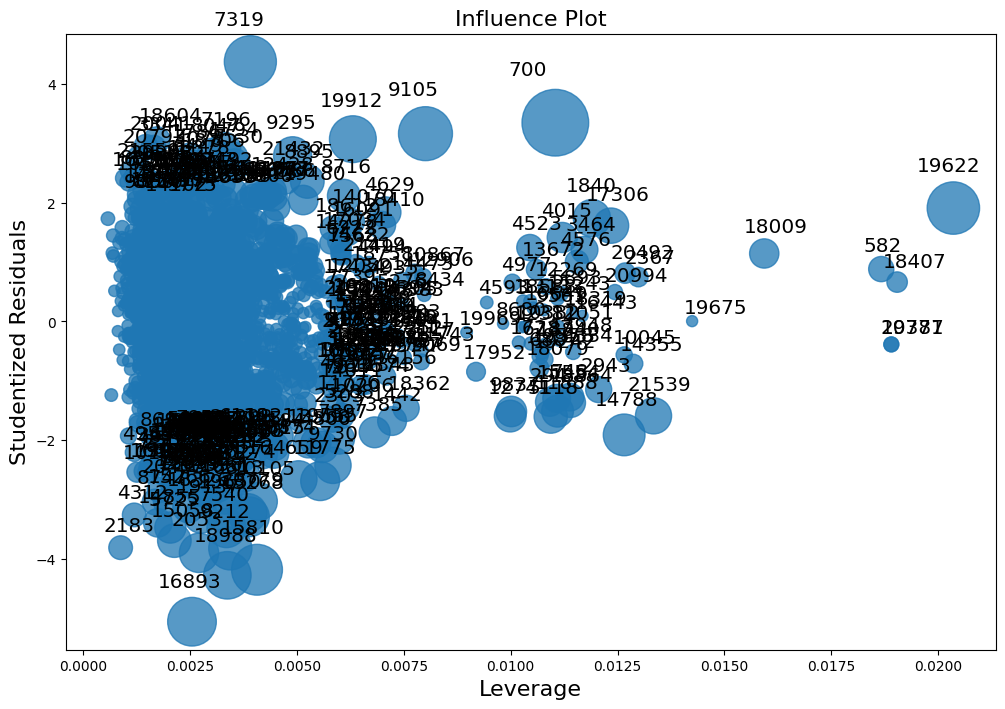

In [2805]:
fig, ax = plt.subplots(figsize = (12,8))
fig = sm.graphics.influence_plot(result_model_ols, ax=ax, criterion='cooks')

In [2806]:
res.head()

predict_val  log_price     error  sq_error
6     12.484917  12.458775  0.026142  0.000683
17    13.274362  13.091904  0.182458  0.033291
25    12.244926  12.358794 -0.113868  0.012966
26    13.480590  13.750439 -0.269849  0.072818
27    13.437352  13.410545  0.026807  0.000719

Feature engineering & build models

In [2807]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
import numpy as np

In [2808]:
df3.head()

bedrooms  bathrooms  floors  waterfront  view  condition  grade  yr_built  yr_renovated  zipcode      lat     long  house_age  reno_age  year  month  log_price  log_sqft_above  log_sqft_living15  log_sqft_basement  log_sqft_lot15
6          3       2.25     2.0           0     0          3      7      1995             0    98003  47.3097 -122.327         28      2023  2014      6  12.458775        7.447168           7.713338               -inf        8.827468
17         4       1.00     1.5           0     0          4      7      1916             0    98103  47.6648 -122.343        107      2023  2014      5  13.091904        7.377759           7.383989               -inf        8.366370
25         3       2.00     1.5           0     0          5      6      1941             0    98002  47.3048 -122.218         82      2023  2014     11  12.358794        7.444249           6.937314               -inf        8.456381
26         3       1.75     2.0           0     0          3      8      1915             0    98119  47.6386 -122.360        108      2023  2014      6  13.750439        7.467371           7.473069            6.55108        8.181161
27         3       1.00     1.5           0     0          5      8      1909             0    98112  47.6221 -122.314        114      2023  2014     12  13.410545        7.244228           7.528332               -inf        8.258681

Variables we used in OLS model: log_price ~  bedrooms + view +grade + lat + year +log_sqft_above + log_sqft_living15 + log_sqft_lot15 + house_age

In [2809]:
df3['view'].astype(object)
df3['year'].astype(object)
df3['grade'].astype(object)

6         7
17        7
25        6
26        8
27        8
31        7
32        7
34        7
35        8
43        7
48        7
63        8
65        7
71        7
88        7
93        8
94        8
101       7
107       8
116       8
119       7
123       7
128       7
133       8
138       6
150       8
158       7
171       7
176       7
177       6
180       7
181       7
188       6
195       8
214       8
225       7
226       8
229       7
234       7
237       7
242       7
250       7
254       7
260       8
265       7
273       7
294       8
337       7
363       8
369       7
370       7
379       7
398       7
400       8
405       9
406       8
407       7
433       7
438       8
447       7
462       7
466       7
491       7
496       9
498       7
506       7
528       6
531       7
535       7
538       7
541       7
557       7
567       7
572       7
582       7
589       8
592       8
593       7
596       8
600       8
603       7
604       7
608       7
611 

In [2810]:
# seperate features and target 
categorical_features = ['view', 'grade','year']
numerical_features = ['lat','bedrooms','log_sqft_above', 'log_sqft_living15', 'log_sqft_lot15', 'house_age']
target = 'log_price'

In [2811]:
# split date in train/test
X_train, X_test, y_train, y_test = train_test_split(df3[categorial_features + numerical_features], df3[target], test_size =0.3, random_state =1234)
#define transformers
cat_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps =[('scaler', StandardScaler())])
#building processor
preprocessor = ColumnTransformer(transformers=[('cat',cat_transformer, categorial_features),('num', num_transformer, numerical_features)])

In [2812]:
linear_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

linear_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['view', 'grade', 'year']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['lat', 'bedrooms',
                                                   'log_sqft_above',
                                                   'log_sqft_living15',
                                                   'log_sqft_lot15',
                                                   'house_age'])])),
                ('regressor', LinearRegression())])

In [2850]:
pred = linear_regression.predict(X_test)
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(pred, y_test))
MSE_LR = np.sqrt(mean_squared_error(pred, y_test))
print(MSE_LR)

0.2307352907500863


In [2814]:
ridge_regression = Pipeline(steps = [
    ('preprocessor', preprocessor), 
    ('regressor', Ridge(alpha =3.0))
])


ridge_regression.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['view', 'grade', 'year']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['lat', 'bedrooms',
                                                   'log_sqft_above',
                                                   'log_sqft_living15',
                                                   'log_sqft_lot15',
                                                   'house_age'])])),
                ('regressor', Ridge(alpha=3.0))])

In [2852]:
pred_ridge = ridge_regression.predict(X_test)
np.sqrt(mean_squared_error(pred_ridge, y_test))
MSE_RG = np.sqrt(mean_squared_error(pred_ridge, y_test))
print(MSE_RG)

0.231280269858688


In [2816]:
lasso_regression = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha = 1.0))
])

lasso_regression.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['view', 'grade', 'year']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['lat', 'bedrooms',
                                                   'log_sqft_above',
                                                   'log_sqft_living15',
                                                   'log_sqft_lot15',
                                                   'house_age'])])),
                ('regressor', Lasso())])

In [2853]:
lasso_pred = lasso_regression.predict(X_test)
np.sqrt(mean_squared_error(lasso_pred, y_test))
MSE_LS = np.sqrt(mean_squared_error(lasso_pred, y_test))
print(MSE_LS)

0.39188029312434824


In [2818]:
elasticnet_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=1.0, l1_ratio = 0.8))
])

elasticnet_regression.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['view', 'grade', 'year']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['lat', 'bedrooms',
                                                   'log_sqft_above',
                                                   'log_sqft_living15',
                                                   'log_sqft_lot15',
                                                   'house_age'])])),
                ('regressor', ElasticNet(l1_ratio=0.8))])

In [2854]:
elasticnet_pred = elasticnet_regression.predict(X_test)
np.sqrt(mean_squared_error(elasticnet_pred, y_test))
MSE_EL = np.sqrt(mean_squared_error(elasticnet_pred, y_test))
print(MSE_EL)

0.39188029312434824


In [2820]:
y_test

15571    13.337475
19406    12.468437
2010     12.513557
16586    12.929991
4356     13.738953
265      12.577636
9957     13.197471
1049     13.482134
1175     13.132314
15558    12.240474
20671    12.644328
10144    12.409013
18916    13.226002
11349    13.102161
20749    12.564823
12182    13.145210
11869    13.329378
10675    12.459551
5076     13.514405
21299    12.691580
14881    12.560244
496      13.493927
1091     13.012549
600      13.136266
20591    12.519057
20924    12.899220
15469    12.721886
17630    13.312990
11783    12.821258
11308    13.012549
10778    12.923912
12598    12.611538
17625    13.182517
16700    13.270783
643      13.500115
17342    13.171154
6569     13.270783
6113     13.288386
18510    12.611538
4270     13.207623
10152    13.415033
11289    13.118355
3667     12.891692
19016    13.351887
17819    12.127570
7517     12.350173
7581     13.428288
16250    13.188151
611      13.384728
5413     12.278393
4985     13.248996
20614    12.639882
14357    13.

In [2824]:
elastic_net_pred = pd.concat([pd.DataFrame(elasticnet_pred).rename(columns={0:'pred'}),y_test.reset_index().drop('index',axis=1).rename(columns={0:'actual'})], axis=1)

In [2825]:
elastic_net_pred['res'] = elastic_net_pred['pred'] - elastic_net_pred['log_price']

categorical_features = ['view', 'grade','year']
numerical_features = ['lat','bedrooms','log_sqft_above', 'log_sqft_living15', 'log_sqft_lot15', 'house_age']

Text(0.5, 1.0, 'log_sqft_living15')

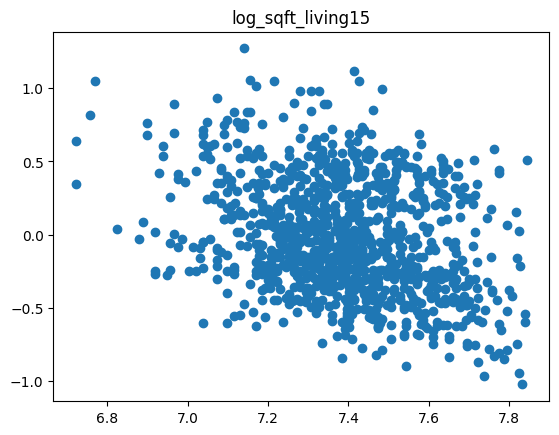

In [2835]:
plt.scatter(X_test['log_sqft_living15'], elastic_net_pred['res'])
plt.title('log_sqft_living15')

Text(0.5, 1.0, 'house_age')

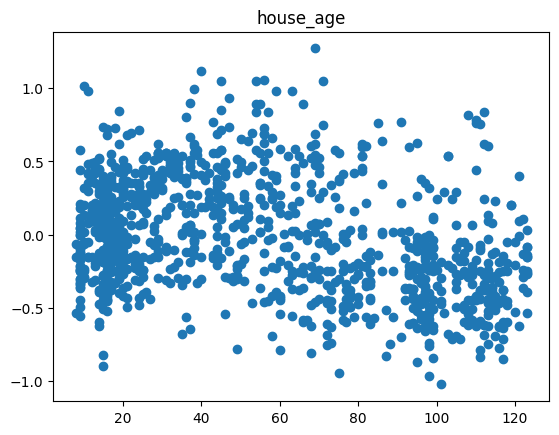

In [2834]:
plt.scatter(X_test['house_age'], elastic_net_pred['res'])
plt.title('house_age')

Text(0.5, 1.0, 'log_sqft_lot15')

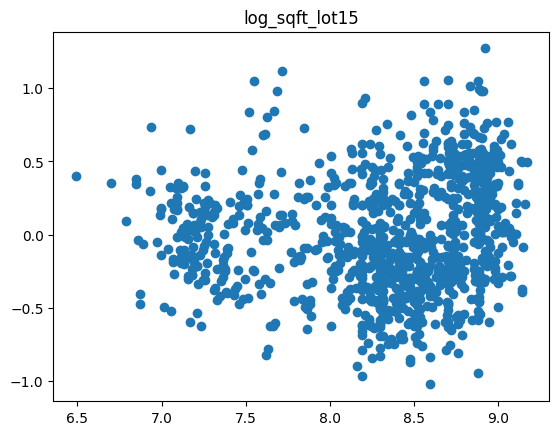

In [2837]:
plt.scatter(X_test['log_sqft_lot15'], elastic_net_pred['res'])
plt.title('log_sqft_lot15')

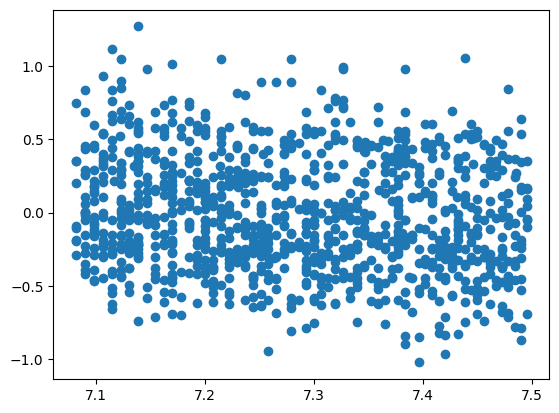

In [2838]:
plt.scatter(X_test['log_sqft_above'], elastic_net_pred['res'])

Text(0.5, 1.0, 'lat')

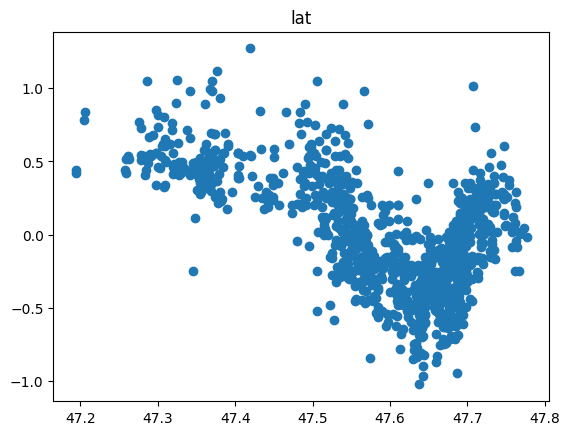

In [2840]:
plt.scatter(X_test['lat'], elastic_net_pred['res'])
plt.title('lat')

Text(0.5, 1.0, 'bedrooms')

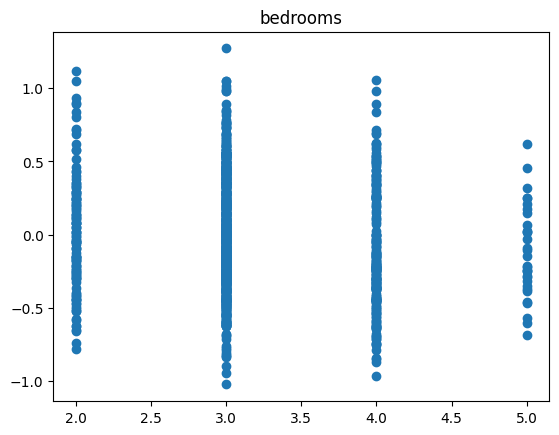

In [2841]:
plt.scatter(X_test['bedrooms'], elastic_net_pred['res'])
plt.title('bedrooms')

Text(0.5, 1.0, 'view')

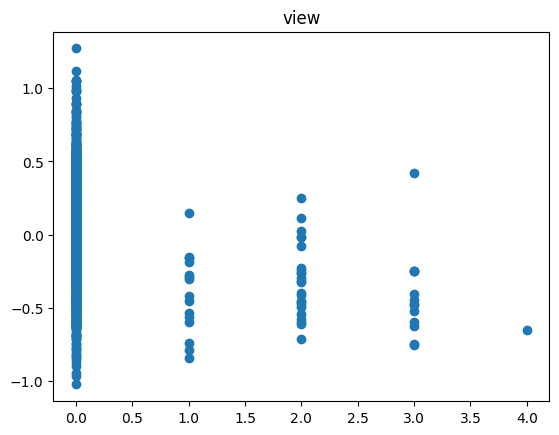

In [2842]:
plt.scatter(X_test['view'], elastic_net_pred['res'])
plt.title('view')

Text(0.5, 1.0, 'grade')

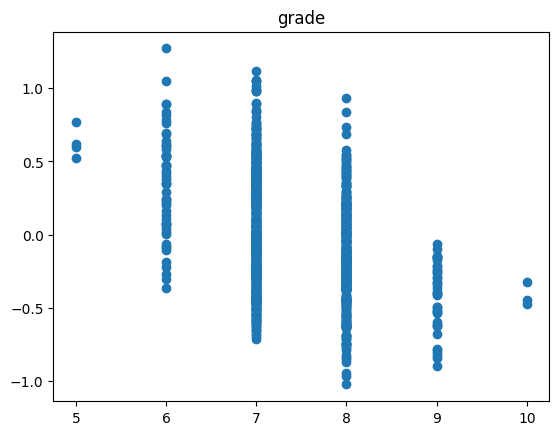

In [2843]:
plt.scatter(X_test['grade'], elastic_net_pred['res'])
plt.title('grade')

Text(0.5, 1.0, 'year')

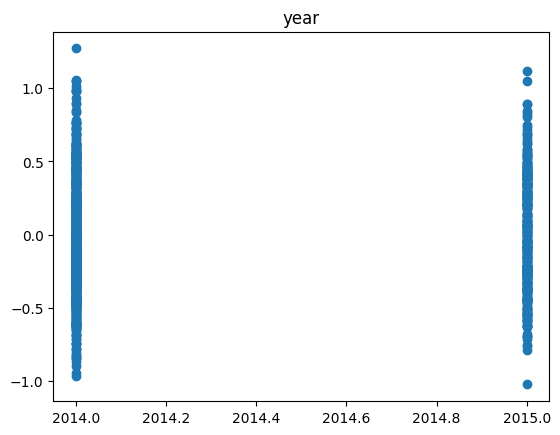

In [2844]:
plt.scatter(X_test['year'], elastic_net_pred['res'])
plt.title('year')

In [2857]:
print({'MSE_OSL': MSE_OSL, 'MSE_LR':MSE_LR, 'MSE_LS': MSE_LS,'MSE_EL': MSE_LR})

{'MSE_OSL': 0.23050653308568753, 'MSE_LR': 0.2307352907500863, 'MSE_LS': 0.39188029312434824, 'MSE_EL': 0.2307352907500863}


First all, I checked the data distribution.

Second, I conducted data cleaning by , remove outliers, drop unneccessary columns, create new meaning columns, convert datatype, convert dummie variables.

Then checked the correlation between variabls, decide to log the price and varaibles related with sqft to normalize the distribution

The most important parts is to play around with combination of variables using OSL model to identify the variables used for building the model by check their P-value, removed those variables with P-value greater than 5%. 

After the data cleaning and identify variables. I build OSL, Ridge, LASSO, and Elastic models, and checked the influencers, leveraging, residual plots. 

Overall, in my analysis, OSL model perform thee best result with the least MSE. 


After exclude some variables with high correlation which caused multicolleanrity. we found 'lat' which reprents location impact the price the most, the other impacting orders from high to low are: log_sqft_living 15, log_sqft_above, grade, view, year(selling year), house_age, bedrooms, however, log_sqft_lot15 have negative impact to price. 
